# ===============================================================
# 06_cGAN - Conditionnal StyleGAN2 (histopathologie)
# ===============================================================

In [1]:
import sys
import os
from pathlib import Path

# --- Environnement dans le container ---
PROJECT_ROOT = Path("/workspace").resolve()  # ou adapte si différent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
DATA_DIR     = PROJECT_ROOT / "data"
CONFIG_DIR   = PROJECT_ROOT / "configs"
CHECKPOINTS  = PROJECT_ROOT / "checkpoints"
SAMPLES_DIR  = PROJECT_ROOT / "samples"
NOTEBOOKS    = PROJECT_ROOT / "notebooks"

# --- Sous-dossiers spécifiques pour ce cGAN ---
CGAN_DIR = NOTEBOOKS / "artifacts" / "cgan"
(CGAR_SAMPLES := CGAN_DIR / "samples").mkdir(parents=True, exist_ok=True)
(CGAR_CKPTS := CGAN_DIR / "checkpoints").mkdir(parents=True, exist_ok=True)

# --- Variables d’environnement (pour histo_dataset etc.) ---
os.environ["CONFIG_DIR"] = str(CONFIG_DIR)
os.environ["PROJECT_ROOT"] = str(PROJECT_ROOT)

# --- Imports communs ---
import torch, random, numpy as np
torch.backends.cudnn.benchmark = True
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print(f"✅ Device : {DEVICE}")
print(f"📂 DATA_DIR = {DATA_DIR}")
print(f"📂 CONFIG_DIR = {CONFIG_DIR}")
print(f"📂 CHECKPOINTS = {CHECKPOINTS}")

✅ Device : cuda
📂 DATA_DIR = /workspace/data
📂 CONFIG_DIR = /workspace/configs
📂 CHECKPOINTS = /workspace/checkpoints


In [2]:
# ===============================================================
#  Dataset & DataLoader pour cGAN (avec labels)
# ===============================================================
from p9dg.histo_dataset import HistoDataset

IMG_SIZE = 128     # tu peux monter à 256 si ta VRAM le permet
BATCH_SIZE = 4
SAMPLES_PER_CLASS_PER_EPOCH = 200

train_ds = HistoDataset(
    root_data=str(DATA_DIR),
    split="train",
    output_size=IMG_SIZE,
    pixel_range="-1_1",          # <- important pour le GAN
    balance_per_class=True,      # équilibre les classes
    samples_per_class_per_epoch=SAMPLES_PER_CLASS_PER_EPOCH,  # limitation du nombre d'images
    return_labels=True,          # <- on récupère les labels ici
    vahadane_enable=True,        # normalisation couleur
    vahadane_device="cuda" if DEVICE == "cuda" else "cpu",
    classes=["TUM", "STR", "NORM"]
)

# --- Collate personnalisé : renvoie (images, labels)
def collate_fn(batch):
    xs, ys, _paths = zip(*batch)
    x = torch.stack(xs, 0)
    y = torch.tensor(ys, dtype=torch.long)
    return x, y

# --- DataLoader
train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,            # tu peux ajuster à 2 si tu vois des blocages
    pin_memory=False,
    drop_last=True,
    collate_fn=collate_fn,
)

print(f"✅ Dataset prêt ({len(train_ds)} images)")
print(f"🧩 {len(train_loader)} batches de {BATCH_SIZE}")


🎨 Référence Vahadane fixée : TUM-QKQCKYSN.tif
🎨 Référence Vahadane auto: TUM-QKQCKYSN.tif
✅ Seuils par classe chargés depuis : /workspace/configs/seuils_par_classe.json
⚖️ Échantillonnage équilibré activé (200 images / classe).
✅ Dataset prêt (600 images)
🧩 150 batches de 4


# 🧩 Cellule 3 — Générateur conditionnel (cGAN)

In [3]:
# ===============================================================
#  Générateur conditionnel (StyleGAN2 simplifié)
# ===============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, z_dim=512, num_classes=9, base_ch=512, img_size=256):
        super().__init__()
        self.z_dim = z_dim
        self.img_size = img_size
        self.embed = nn.Embedding(num_classes, z_dim)  # embedding de condition

        # --- couche d'entrée : dense -> feature map 4x4
        self.fc = nn.Sequential(
            nn.Linear(z_dim, base_ch * 4 * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # --- upsampling progressif jusqu'à 256x256
        layers = []
        ch = base_ch
        res = 4
        while res < img_size:
            layers += [
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(ch, max(ch // 2, 64), kernel_size=3, padding=1),
                nn.LeakyReLU(0.2, inplace=True),
            ]
            ch = max(ch // 2, 64)
            res *= 2

        self.convs = nn.Sequential(*layers)

        # --- sortie RGB
        self.to_rgb = nn.Sequential(
            nn.Conv2d(ch, 3, kernel_size=1),
            nn.Tanh()  # [-1, 1]
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, z, y):
        # z: (B, z_dim), y: (B,)
        cond = self.embed(y)
        z_cond = z + cond                    # injection simple
        x = self.fc(z_cond).view(-1, 512, 4, 4)
        img = self.to_rgb(self.convs(x))
        return img


In [4]:
# Test unitaire
G = Generator(z_dim=512, num_classes=9, img_size=256).to(DEVICE)
z = torch.randn(4, 512, device=DEVICE)
labels = torch.randint(0, 9, (4,), device=DEVICE)
out = G(z, labels)
print(f"🧠 Sortie G: {out.shape}, min={out.min().item():.2f}, max={out.max().item():.2f}")


🧠 Sortie G: torch.Size([4, 3, 256, 256]), min=-0.15, max=0.35


## 🧩 Cellule 4 — Discriminateur conditionnel (Projection Discriminator)

In [5]:
# ===============================================================
#  Discriminateur conditionnel (Projection)
# ===============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn.utils import spectral_norm as SN


class MinibatchStdDev(nn.Module):
    """Ajoute la déviation standard inter-échantillons sur un canal supplémentaire."""
    def __init__(self, group_size=16, eps=1e-8):
        super().__init__()
        self.group_size = group_size
        self.eps = eps

    def forward(self, x):
        N, C, H, W = x.shape
        g = min(self.group_size, N)
        y = x.view(g, -1, C, H, W)               # (g, n, C, H, W)
        y = y - y.mean(dim=0)
        y = torch.sqrt(y.pow(2).mean(dim=0) + self.eps)
        y = y.mean(dim=(1, 2, 3), keepdim=True)  # (n,1,1,1)
        y = y.repeat(g, 1, H, W)
        return torch.cat([x, y], dim=1)          # +1 canal


class Discriminator(nn.Module):
    def __init__(self, num_classes=9, base_ch=64, img_size=256,
                 use_spectral_norm=True, use_minibatch_std=True):
        super().__init__()
        ch = base_ch
        layers = []

        # --- bloc d'entrée
        layers += [
            SN(nn.Conv2d(3, ch, 3, padding=1)) if use_spectral_norm else nn.Conv2d(3, ch, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        ]

        # --- downsampling progressif (256 -> 4)
        res = img_size
        max_ch = 1024
        while res > 4:
            next_ch = min(ch * 2, max_ch)
            conv = nn.Conv2d(ch, next_ch, 3, padding=1)
            if use_spectral_norm:
                conv = SN(conv)
            layers += [conv, nn.LeakyReLU(0.2, inplace=True), nn.AvgPool2d(2)]
            ch = next_ch
            res //= 2

        # --- minibatch stddev + couche finale
        if use_minibatch_std:
            layers += [MinibatchStdDev(group_size=16)]

        layers += [
            SN(nn.Conv2d(ch + (1 if use_minibatch_std else 0), ch, 3, padding=1)) if use_spectral_norm
            else nn.Conv2d(ch + (1 if use_minibatch_std else 0), ch, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        ]

        self.cnn = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = SN(nn.Linear(ch, 1)) if use_spectral_norm else nn.Linear(ch, 1)
        self.embed = nn.Embedding(num_classes, ch)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, y):
        h = self.cnn(x)
        h = self.pool(h).view(x.size(0), -1)
        logit = self.fc(h)
        emb = self.embed(y)
        proj = (h * emb).sum(dim=1, keepdim=True)
        return logit + proj


In [6]:
D = Discriminator(num_classes=9, img_size=256).to(DEVICE)
x = torch.randn(4, 3, 256, 256, device=DEVICE)
labels = torch.randint(0, 9, (4,), device=DEVICE)
out = D(x, labels)
print(f"🧩 Sortie D: {out.shape}, moyenne={out.mean().item():.3f}")


🧩 Sortie D: torch.Size([4, 1]), moyenne=0.282


## 🧩 Cellule 5 — Initialisation, EMA & Optimizers

In [8]:
# ===============================================================
#  Initialisation des modèles, EMA et optimizers
# ===============================================================
import copy
from torch import nn

# --- Fonctions utilitaires reprises du StyleGAN précédent ---
def requires_grad(model: nn.Module, flag: bool = True):
    for p in model.parameters():
        p.requires_grad_(flag)

@torch.no_grad()
def ema_update(ema_model: nn.Module, model: nn.Module, decay=0.999):
    for p_ema, p in zip(ema_model.parameters(), model.parameters()):
        p_ema.data.mul_(decay).add_(p.data, alpha=1.0 - decay)

# --- Hyperparamètres globaux (comme dans le StyleGAN précédent) ---
BETAS_G = (0.0, 0.99)
BETAS_D = (0.0, 0.99)
Z_DIM = 512
LR_G = 5e-4
LR_D = LR_G * 0.25       # Discriminateur plus doux
R1_GAMMA = 80.0
R1_EVERY = 8      # plus fréquent
ADA_TARGET = 0.55
ADA_SPEED = 0.003
ADA_MAX_P = 0.20  # plafonne ADA
EMA_DECAY = 0.999
ADA_FREEZE_UNTIL = 200  # ne pas bouger p au tout début
ADA_DEADBAND = 0.02           # zone neutre autour de la cible
ADA_STATE = {"p": 0.0, "acc_ema": None}

# --- Label smoothing léger côté D ---
SMOOTH_REAL = (0.90, 1.00)
SMOOTH_FAKE = (0.00, 0.10)
# --- Seuil de "D trop confiant" + clipping ---
CONFIDENT_ACC = 0.90
CLIP_D = 5.0
CLIP_G = 10.0

# seuils
ACC_UPPER = 0.85
FREEZE_STEPS = 3

# --- Instanciation des modèles ---
G = Generator(z_dim=Z_DIM, num_classes=9, img_size=256).to(DEVICE)
D = Discriminator(num_classes=9, img_size=256).to(DEVICE)

# --- Copie EMA du générateur ---
G_ema = copy.deepcopy(G).eval()
for p in G_ema.parameters():
    p.requires_grad_(False)

# --- Optimizers Adam (paramètres du StyleGAN2) ---
opt_G = torch.optim.Adam(G.parameters(), lr=LR_G, betas=BETAS_G)
opt_D = torch.optim.Adam(D.parameters(), lr=LR_D, betas=BETAS_D)

# ===========================
# TTUR dynamique + freeze(D)
# ===========================
from types import SimpleNamespace

TTUR = SimpleNamespace(
    acc_upper = 0.9,   # seuil où D est "trop confiant"
    acc_lower = 0.75,   # seuil où on relâche l'intervention
    freeze_steps = 8,   # nb d'itérations sans update D
    factor_D = 0.25,     # on réduit LR_D
    factor_G = 1.5,     # on augmente LR_G
    lrD_min = 2e-5,     # bornes de sécurité
    lrG_max = 2e-3,
    cooldown = 100      # pas d'intervention répétée avant N steps
)

freeze_D_for = 0
cooldown_left = 0
base_lr_D = opt_D.param_groups[0]['lr']
base_lr_G = opt_G.param_groups[0]['lr']

def _set_lr(opt, new_lr, bound=None, is_min=False):
    if bound is not None:
        new_lr = max(new_lr, bound) if is_min else min(new_lr, bound)
    for pg in opt.param_groups:
        pg['lr'] = new_lr

def _scale_lr(opt, factor, bound=None, is_min=False):
    for pg in opt.param_groups:
        lr = pg['lr'] * factor
        if bound is not None:
            lr = max(lr, bound) if is_min else min(lr, bound)
        pg['lr'] = lr


# --- Impression de synthèse ---
n_params_G = sum(p.numel() for p in G.parameters() if p.requires_grad)
n_params_D = sum(p.numel() for p in D.parameters() if p.requires_grad)

print("✅ Modèles initialisés")
print(f"🧬 G : {n_params_G/1e6:.2f} M paramètres")
print(f"🧱 D : {n_params_D/1e6:.2f} M paramètres")
print(f"🚀 Optimizers : Adam(G) LR={LR_G}, Adam(D) LR={LR_D}")
print(f"EMA decay = {EMA_DECAY}")


✅ Modèles initialisés
🧬 G : 5.87 M paramètres
🧱 D : 34.60 M paramètres
🚀 Optimizers : Adam(G) LR=0.0005, Adam(D) LR=0.000125
EMA decay = 0.999


In [9]:
z = torch.randn(2, Z_DIM, device=DEVICE)
labels = torch.tensor([0, 1], device=DEVICE)
imgs = G(z, labels)
print(f"Sortie test G: {imgs.shape}, min={imgs.min():.2f}, max={imgs.max():.2f}")
logits = D(imgs, labels)
print(f"Sortie test D: {logits.shape}, mean={logits.mean():.3f}")


Sortie test G: torch.Size([2, 3, 256, 256]), min=-0.26, max=0.35
Sortie test D: torch.Size([2, 1]), mean=0.019


## 🧩 Cellule 6 — Losses, R1, instance_noise, et ADA minimal

In [10]:
# ===============================================================
#  Fonctions de perte, régularisation R1 et ADA minimal
# ===============================================================
import torch.nn.functional as F

# ===========================
# Instance noise — version robuste
# ===========================
import math

def add_instance_noise(x,
                       step: int,
                       *,
                       max_sigma: float = 0.08,  # un poil + fort au début
                       min_sigma: float = 0.005, # plancher
                       tau: int = 10_000,        # vitesse d’amortissement (itérations)
                       pixel_range: str = "0_1"  # "0_1" ou "-1_1"
                      ):
    """
    Bruit gaussien N(0, sigma) décroissant : sigma(step) = max_sigma * exp(-step / tau), borné par min_sigma.
    - AMP-safe (pas de torch.tensor CPU)
    - Clamp selon l’espace de pixels pour éviter les sorties hors-plage
    """
    # planning lisse, simple à raisonner
    sigma = max(max_sigma * math.exp(-step / float(tau)), min_sigma)

    if sigma <= 0.0:
        return x

    # génère le bruit avec le bon dtype/device (important sous autocast)
    eps = torch.randn_like(x)

    y = x + sigma * eps

    # clamp selon l’échelle utilisée par ton dataset / GAN
    if pixel_range == "-1_1":
        y = y.clamp_(-1.0, 1.0)
    else:  # par défaut [0,1]
        y = y.clamp_(0.0, 1.0)

    return y
    

# --- Pertes StyleGAN2 (non-saturating) ---
def d_logistic_loss(real_pred, fake_pred):
    """Loss du discriminateur (NS-GAN)."""
    return F.softplus(-real_pred).mean() + F.softplus(fake_pred).mean()

def g_nonsat_loss(fake_pred):
    """Loss du générateur (NS-GAN)."""
    return F.softplus(-fake_pred).mean()

# --- Hinge losses ---
def d_hinge_loss(real_pred, fake_pred):
    # max(0, 1 - real) + max(0, 1 + fake)
    real_term = torch.relu(1.0 - real_pred).mean()
    fake_term = torch.relu(1.0 + fake_pred).mean()
    return real_term + fake_term

def g_hinge_loss(fake_pred):
    # -E[D(fake)]
    return -fake_pred.mean()


# --- Régularisation R1 (lazy) ---
def r1_penalty(real_img, real_pred):
    """Gradient penalty R1 (∥∇x D(x)∥²)."""
    grad = torch.autograd.grad(
        outputs=real_pred.sum(),
        inputs=real_img,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    grad = grad.view(grad.size(0), -1)
    return grad.pow(2).sum(1).mean()


def ada_augment(x, p, translate=0.07, color=0.1):
    """Applique des augmentations légères avec probabilité p."""
    if p <= 0:
        return x
    # flip horizontal
    if torch.rand(1, device=x.device) < p:
        x = torch.flip(x, dims=[-1])
    # jitter couleur léger
    if torch.rand(1, device=x.device) < p:
        x = x + torch.randn_like(x) * color
        x = torch.clamp(x, -1, 1)
    return x

def ada_update(real_logits, state=ADA_STATE, target=ADA_TARGET, speed=ADA_SPEED,
               max_p=ADA_MAX_P, decay=0.99):
    with torch.no_grad():
        acc = (torch.sigmoid(real_logits) > 0.5).float().mean().item()
        state["acc_ema"] = acc if state.get("acc_ema") is None else (decay*state["acc_ema"] + (1.0-decay)*acc)

        if global_step < ADA_FREEZE_UNTIL:
            return state

        err = state["acc_ema"] - target
        if abs(err) <= ADA_DEADBAND:
            delta = 0.0
        else:
            delta = speed * (1.0 if err > 0 else -1.0)
        state["p"] = float(min(max(state["p"] + delta, 0.0), max_p))
        return state

In [11]:
x = torch.randn(2, 3, 256, 256, device=DEVICE)
p = 0.5
x_aug = ada_augment(x, p)
print(f"ADA test -> diff moyenne : {(x - x_aug).abs().mean():.4f}, p={p}")


ADA test -> diff moyenne : 0.2208, p=0.5


## 🧩 Cellule 7 — Boucle d’entraînement complète

In [12]:
# ===============================================================
#  Initialisation du logger de métriques
# ===============================================================
import pandas as pd

history = {
    "step": [],
    "epoch": [],
    "loss_D": [],
    "loss_G": [],
    "loss_R1": [],
    "p_ADA": [],
    "acc": [],
    "acc_ema": [],
}

def log_metrics(step, epoch, d_loss, g_loss, r1, p, acc, acc_ema):
    history["step"].append(step)
    history["epoch"].append(epoch)
    history["loss_D"].append(float(d_loss))
    history["loss_G"].append(float(g_loss))
    history["loss_R1"].append(float(r1))
    history["p_ADA"].append(float(p))
    history["acc"].append(float(acc))
    history["acc_ema"].append(float(acc_ema))


In [13]:
# ===============================================================
#  AMP + GradScaler + R1 en fp32
# ===============================================================
from torch.amp import autocast, GradScaler

AMP_DEVICE = "cuda" if DEVICE == "cuda" else "cpu"
USE_AMP = True
scaler_G = GradScaler(device=AMP_DEVICE, enabled=USE_AMP)
scaler_D = GradScaler(device=AMP_DEVICE, enabled=USE_AMP)

def r1_fp32(real_img, real_pred):
    """R1 en fp32 pour stabilité/mémoire."""
    # cast explicite
    real_img_f32 = real_img.float().detach().requires_grad_(True)
    real_pred_f32 = D(real_img_f32, real_y)  # repasse par D en fp32
    grad = torch.autograd.grad(
        outputs=real_pred_f32.sum(),
        inputs=real_img_f32,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    r1 = grad.pow(2).reshape(grad.size(0), -1).sum(1).mean()
    return 0.5 * R1_GAMMA * r1


In [14]:
# ===============================================================
#  Boucle d'entraînement (AMP + R1 fp32 + guard OOM)
# ===============================================================
import itertools, time
import torchvision.utils as vutils
from tqdm.notebook import tqdm

EPOCHS = 3
global_step = 0
fixed_z = torch.randn(9 * 8, Z_DIM, device=DEVICE)
fixed_labels = torch.tensor(list(itertools.chain.from_iterable([[i]*8 for i in range(9)])),
                            device=DEVICE, dtype=torch.long)
# Pour renforcer le bruit
INSTANCE_NOISE = dict(max_sigma=0.12, min_sigma=0.01, tau=8000, pixel_range="0_1")

print(f"🧩 Démarrage de l'entraînement sur {len(train_loader)} batches × {EPOCHS} epochs")

for epoch in range(EPOCHS):
    t0 = time.time()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for real_x, real_y in pbar:
        global_step += 1
        real_x = real_x.to(DEVICE, non_blocking=True)
        real_y = real_y.to(DEVICE, non_blocking=True)
        p = ADA_STATE["p"]
        
        try:
            # -----------------------------
            # 1) Discriminator
            # -----------------------------
            requires_grad(D, True); requires_grad(G, False)
            opt_D.zero_grad(set_to_none=True)
            
            # instance noise
            real_x_noisy = add_instance_noise(real_x, global_step, **INSTANCE_NOISE)
            z = torch.randn(real_x.size(0), Z_DIM, device=DEVICE)
            
            with autocast(device_type=AMP_DEVICE, enabled=USE_AMP):
                # latent jitter (optionnel si tu utilises déjà instance noise)
                z_noisy = z + 0.01 * torch.randn_like(z)
            
                fake_x = G(z_noisy, real_y).detach()
                fake_x_noisy = add_instance_noise(fake_x, global_step, **INSTANCE_NOISE)
            
                real_x_aug = ada_augment(real_x_noisy, p)
                fake_x_aug = ada_augment(fake_x_noisy, p)
            
                real_logits = D(real_x_aug, real_y)
                fake_logits = D(fake_x_aug, real_y)
                d_loss = d_hinge_loss(real_logits, fake_logits)   # d_logistic_loss(real_logits, fake_logits)

                # ---- Mesure de confiance courante de D (instante + EMA courante)
                with torch.no_grad():
                    acc_inst = (torch.sigmoid(real_logits) > 0.5).float().mean().item()
                acc_ema_prev = (ADA_STATE.get("acc_ema") or acc_inst)  # EMA du step précédent
                
                # ---- Déclencheur TTUR+freeze quand D s'emballe
                if (acc_ema_prev > TTUR.acc_upper) and (freeze_D_for == 0) and (cooldown_left == 0):
                    _scale_lr(opt_D, TTUR.factor_D, bound=TTUR.lrD_min, is_min=True)   # ↓ LR_D
                    _scale_lr(opt_G, TTUR.factor_G, bound=TTUR.lrG_max, is_min=False)  # ↑ LR_G
                    freeze_D_for = TTUR.freeze_steps
                    cooldown_left = TTUR.cooldown
                    if global_step % 50 == 0:
                        print(f"⛔ D freeze {freeze_D_for} steps | LR_D={opt_D.param_groups[0]['lr']:.1e} | LR_G={opt_G.param_groups[0]['lr']:.1e}")
                
                # ---- Récupération progressive si D est redescendu
                elif acc_ema_prev < TTUR.acc_lower:
                    # ramène doucement vers les LR de base
                    for pg in opt_D.param_groups:
                        pg['lr'] = min(base_lr_D, max(TTUR.lrD_min, pg['lr'] * 1.05))
                    for pg in opt_G.param_groups:
                        pg['lr'] = max(base_lr_G, min(TTUR.lrG_max, pg['lr'] * 0.95))
                
                # ---- décrémente le cooldown au fil des steps
                if cooldown_left > 0:
                    cooldown_left -= 1


            # --- R1 conditionnel et adaptatif ---
            too_confident = (ADA_STATE.get("acc_ema") or 0.5) > CONFIDENT_ACC
            do_r1 = (global_step % R1_EVERY) == 0 or too_confident
            
            if do_r1:
                r1_gamma = 10.0 if too_confident else 5.0
            
                # 1️⃣ détache les vrais batchs, on veut les gradients w.r.t. image
                real_r1 = real_x.detach().requires_grad_(True)
            
                # 2️⃣ applique les mêmes augmentations géométriques (flip, crop, etc.)
                #    mais sans bruit additif (instance noise)
                with autocast(device_type=AMP_DEVICE, enabled=USE_AMP):
                    real_r1_aug = ada_augment(real_r1, p, color=0.0)
                    real_pred_r1 = D(real_r1_aug, real_y)
            
                # 3️⃣ calcul du penalty (norme du gradient)
                r1_pen = r1_penalty(real_r1_aug, real_pred_r1)
            
                # 4️⃣ pondération standard
                r1 = 0.5 * r1_gamma * r1_pen
            else:
                r1 = torch.tensor(0.0, device=DEVICE)

            
            d_total = d_loss + r1

            # --- Dynamic update ratio: si D trop confiant, on saute 1 update sur 2 ---
            skip_D = (freeze_D_for > 0) or (too_confident and (global_step % 2 == 1))

            if not skip_D:
                scaler_D.scale(d_total).backward()
                # >>> clipping pour éviter les sauts de gradient
                scaler_D.unscale_(opt_D)
                nn.utils.clip_grad_norm_(D.parameters(), CLIP_D)
                scaler_D.step(opt_D)
                scaler_D.update()
            if freeze_D_for > 0:
                freeze_D_for -= 1


            # ADA (capé + lent)
            ada_update(real_logits.detach())

            # -----------------------------
            # 2) Generator
            # -----------------------------
            requires_grad(D, False); requires_grad(G, True)
            opt_G.zero_grad(set_to_none=True)
            
            z = torch.randn(real_x.size(0), Z_DIM, device=DEVICE)
            with autocast(device_type=AMP_DEVICE, enabled=USE_AMP):
                z_noisy = z + 0.01 * torch.randn_like(z)  # optionnel
                fake_x = G(z_noisy, real_y)
            
                # On garde le même protocole que côté D
                fake_x_noisy = add_instance_noise(fake_x, global_step, **INSTANCE_NOISE)
                fake_x_aug   = ada_augment(fake_x_noisy, p)
            
                fake_logits = D(fake_x_aug, real_y)
                g_loss = g_loss = g_hinge_loss(fake_logits)  # g_nonsat_loss(fake_logits)
    
            scaler_G.scale(g_loss).backward()
            scaler_G.unscale_(opt_G)
            nn.utils.clip_grad_norm_(G.parameters(), CLIP_G)
            scaler_G.step(opt_G)
            scaler_G.update()

            # EMA
            ema_update(G_ema, G, decay=EMA_DECAY)

            # --- Accuracy instantanée et EMA du D (logs) ---
            with torch.no_grad():
                acc = (torch.sigmoid(real_logits) > 0.5).float().mean().item()
                acc_ema = ADA_STATE.get("acc_ema", acc)

            log_metrics(global_step, epoch, d_loss.item(), g_loss.item(), r1.item(),
                        ADA_STATE["p"], acc, acc_ema)

            
            if global_step % 25 == 0:
                pbar.set_postfix({
                    "D": f"{d_loss.item():.3f}",
                    "G": f"{g_loss.item():.3f}",
                    "R1": f"{r1.item():.3f}",
                    "p_ADA": f"{ADA_STATE['p']:.2f}",
                    "acc": f"{acc:.2f}",
                    "acc_ema": f"{acc_ema:.2f}",
                    "LR_D": f"{opt_D.param_groups[0]['lr']:.1e}",
                    "LR_G": f"{opt_G.param_groups[0]['lr']:.1e}",
                    "frzD": freeze_D_for,
                })


            if global_step % 200 == 0:
                with torch.no_grad():
                    G_ema.eval()
                    with autocast(device_type=AMP_DEVICE, enabled=False):
                        imgs = G_ema(fixed_z, fixed_labels)
                    save_path = SAMPLES_DIR / f"cgan_{global_step:06d}.png"
                    vutils.save_image(imgs, save_path, nrow=8, normalize=True, value_range=(-1, 1))
                print(f"💾 Samples → {save_path}")

        except RuntimeError as e:
            if "CUDA out of memory" in str(e):
                print("⚠️ OOM détecté → baisse BATCH_SIZE ou remonte R1_EVERY (ex. 16→32).")
                torch.cuda.empty_cache()
                raise
            else:
                raise

    print(f"✅ Epoch {epoch+1}/{EPOCHS} finie en {time.time()-t0:.1f}s | p_ADA={ADA_STATE['p']:.2f} | LR_D={opt_D.param_groups[0]['lr']:.1e}")


🧩 Démarrage de l'entraînement sur 150 batches × 3 epochs


Epoch 1/3:   0%|          | 0/150 [00:00<?, ?it/s]

✅ Epoch 1/3 finie en 40.2s | p_ADA=0.00 | LR_D=2.0e-05


Epoch 2/3:   0%|          | 0/150 [00:00<?, ?it/s]

💾 Samples → /workspace/samples/cgan_000200.png
✅ Epoch 2/3 finie en 37.8s | p_ADA=0.20 | LR_D=2.0e-05


Epoch 3/3:   0%|          | 0/150 [00:00<?, ?it/s]

💾 Samples → /workspace/samples/cgan_000400.png
✅ Epoch 3/3 finie en 34.1s | p_ADA=0.20 | LR_D=2.0e-05


In [15]:
# Vidage RAM GPU
torch.cuda.empty_cache()

📊 Log du run sauvegardé → /workspace/samples/run_20251029_112004/train_log.csv
🧾 Métadonnées du run → /workspace/samples/run_20251029_112004/meta.json


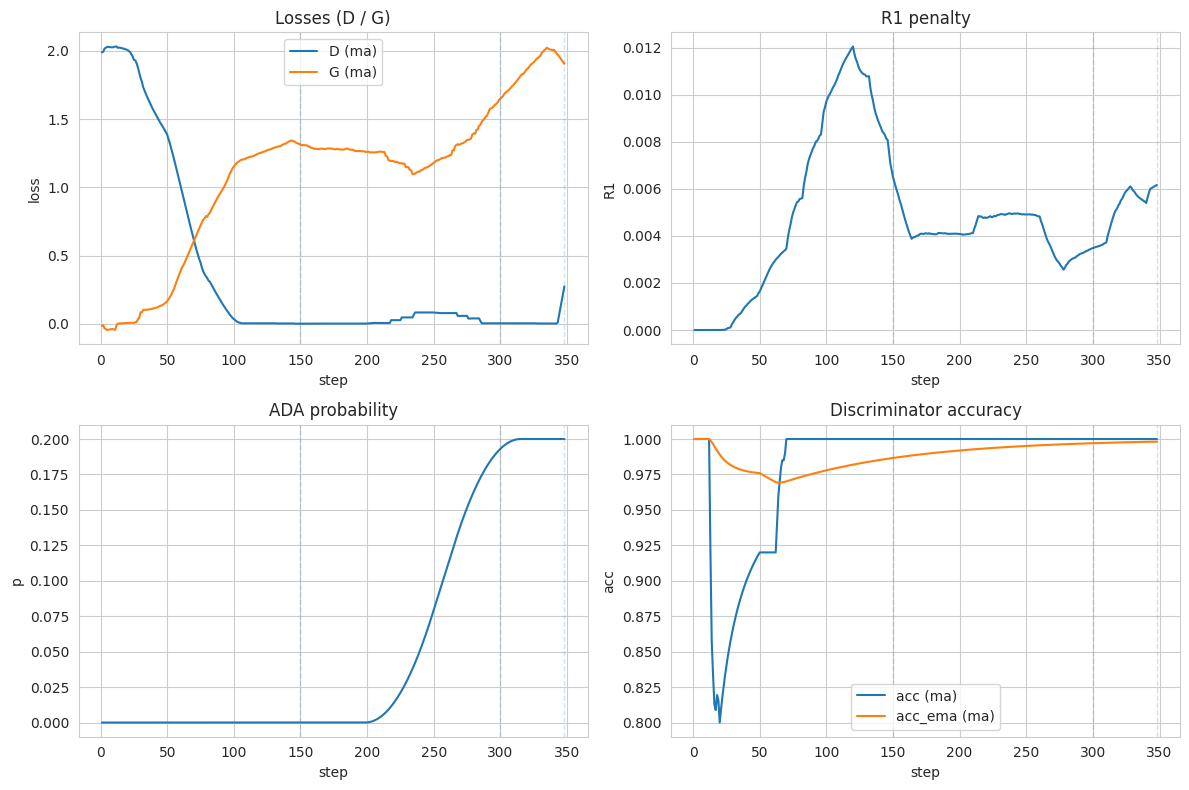

🖼️ Courbes sauvegardées → /workspace/samples/run_20251029_112004/curves.png


In [16]:
# ===============================================================
#  Sauvegarde des courbes & logs — 1 dossier / 1 run
#  -> Un CSV unique par run (pas de CSV par epoch)
# ===============================================================
import os, time, json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Identifiant de RUN + dossier dédié
RUN_ID = time.strftime("%Y%m%d_%H%M%S")
RUN_DIR = SAMPLES_DIR / f"run_{RUN_ID}"
RUN_DIR.mkdir(parents=True, exist_ok=True)

# 2) DataFrame à partir de l'historique
df = pd.DataFrame(history).copy()
df = df.dropna(subset=["loss_D", "loss_G"]).reset_index(drop=True)  # sécurité

# 3) Sauvegarde du log (unique pour ce run)
log_path = RUN_DIR / "train_log.csv"
df.to_csv(log_path, index=False)
print(f"📊 Log du run sauvegardé → {log_path}")

# (optionnel) métadonnées du run pour reproductibilité
meta = {
    "RUN_ID": RUN_ID,
    "IMG_SIZE": int(globals().get("IMG_SIZE", -1)),
    "BATCH_SIZE": int(globals().get("BATCH_SIZE", -1)),
    "Z_DIM": int(globals().get("Z_DIM", -1)),
    "LR_G": float(globals().get("LR_G", -1)),
    "LR_D": float(globals().get("LR_D", -1)),
    "R1_GAMMA": float(globals().get("R1_GAMMA", -1)),
    "R1_EVERY": int(globals().get("R1_EVERY", -1)),
    "ADA_TARGET": float(globals().get("ADA_TARGET", -1)),
    "ADA_SPEED": float(globals().get("ADA_SPEED", -1)),
    "ADA_MAX_P": float(globals().get("ADA_MAX_P", -1)),
    "EPOCHS": int(globals().get("EPOCHS", -1)),
}
with open(RUN_DIR / "meta.json", "w") as f:
    json.dump(meta, f, indent=2)
print(f"🧾 Métadonnées du run → {RUN_DIR / 'meta.json'}")

# 4) Moyennes glissantes pour lisibilité
for k in ["loss_D","loss_G","loss_R1","p_ADA","acc","acc_ema"]:
    if k in df.columns:
        df[f"{k}_ma"] = df[k].rolling(window=50, min_periods=1).mean()

# 5) Figure 2x2 (losses / R1 / ADA / accuracies)
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Losses
sns.lineplot(ax=axes[0,0], data=df, x="step", y="loss_D_ma", label="D (ma)")
sns.lineplot(ax=axes[0,0], data=df, x="step", y="loss_G_ma", label="G (ma)")
axes[0,0].set_title("Losses (D / G)"); axes[0,0].set_xlabel("step"); axes[0,0].set_ylabel("loss")

# R1
sns.lineplot(ax=axes[0,1], data=df, x="step", y="loss_R1_ma")
axes[0,1].set_title("R1 penalty"); axes[0,1].set_xlabel("step"); axes[0,1].set_ylabel("R1")

# ADA
sns.lineplot(ax=axes[1,0], data=df, x="step", y="p_ADA_ma")
axes[1,0].set_title("ADA probability"); axes[1,0].set_xlabel("step"); axes[1,0].set_ylabel("p")

# Accuracies
sns.lineplot(ax=axes[1,1], data=df, x="step", y="acc_ma", label="acc (ma)")
sns.lineplot(ax=axes[1,1], data=df, x="step", y="acc_ema_ma", label="acc_ema (ma)")
axes[1,1].set_title("Discriminator accuracy"); axes[1,1].set_xlabel("step"); axes[1,1].set_ylabel("acc")

# Repères de fin d’epoch (lisibilité)
if "epoch" in df.columns and not df.empty:
    for ax in axes.ravel():
        steps_epoch = df.groupby("epoch")["step"].max().tolist()
        for s in steps_epoch:
            ax.axvline(s, linestyle="--", alpha=0.2, linewidth=1)

plt.tight_layout()
fig_path = RUN_DIR / "curves.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print(f"🖼️ Courbes sauvegardées → {fig_path}")